In [1]:
# Imports and other setup

import os
import random
import pandas as pd
from funman import MODE_ODEINT, FunmanWorkRequest, GeneratedPetriNetModel
from funman_demo.helpers import run, get_model, setup_common, get_request, report, runtime_stats_dataframe


RESOURCES = "../resources"
SAVED_RESULTS_DIR = "./out"

EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet","monthly-demo", "2024-09")
REQUEST_PATH = os.path.join(EXAMPLE_DIR, "sir_request1.json")

models = {
    "sir": os.path.join(EXAMPLE_DIR, "sir.json"),
}
requests = {
    "sir": REQUEST_PATH,
    "sir_stratified": os.path.join(EXAMPLE_DIR, "sir_stratified_request.json"),
    "sir_bounded_stratified": os.path.join(EXAMPLE_DIR, "sir_stratified_request.json"),
    "sir_bounded": os.path.join(EXAMPLE_DIR, "sir_bounded_request.json"),
    "sir_bounded_manual": os.path.join(EXAMPLE_DIR, "sir_bounded_request.json"),
    "sir_abstract_stratified_bounded": os.path.join(EXAMPLE_DIR, "sir_bounded_request.json")
}
request_params = {}
request_results = {}

In [2]:
# Constants for the scenario

MAX_TIME=40                 # Number of timesteps for simulation
STEP_SIZE=1                 # Granularity of steps reported (not the granularity of simulation)
MODE=MODE_ODEINT            # Use numeric integration (not SMT)
model_str = "sir"           # Model to use
beta_modifier = 0.00001     # Amount to adjust +/- beta parameter 
timepoints = list(range(0, MAX_TIME+STEP_SIZE, STEP_SIZE))

1 points
         beta gamma model_size time_horizon             total_time
sir  0.000315   0.1          7           40 0 days 00:00:00.152909


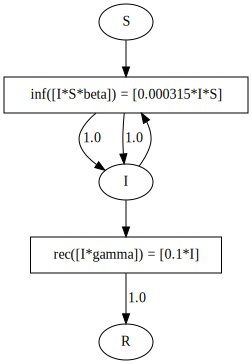

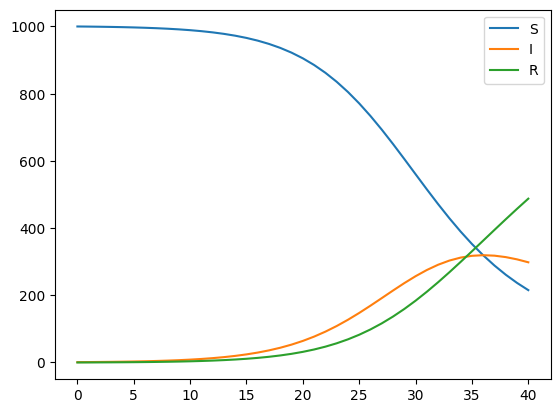

In [3]:
# 1) Process Base Model

(base_model, _) = get_model(models[model_str])
funman_request = get_request(requests[model_str])
setup_common(funman_request, timepoints, mode=MODE)
base_results = run(funman_request, model_str, models)
report(base_results, model_str, base_model._state_var_names() + base_model._observable_names(), request_results, request_params)
base_model.to_dot()

1 points
                 beta gamma             total_time model_size time_horizon  \
sir          0.000315   0.1 0 days 00:00:00.152909          7           40   
sir_bounded       NaN   NaN 0 days 00:00:00.682955         20           40   

              beta_lb   beta_ub gamma_lb gamma_ub  
sir               NaN       NaN      NaN      NaN  
sir_bounded  0.000305  0.000325      0.1      0.1  


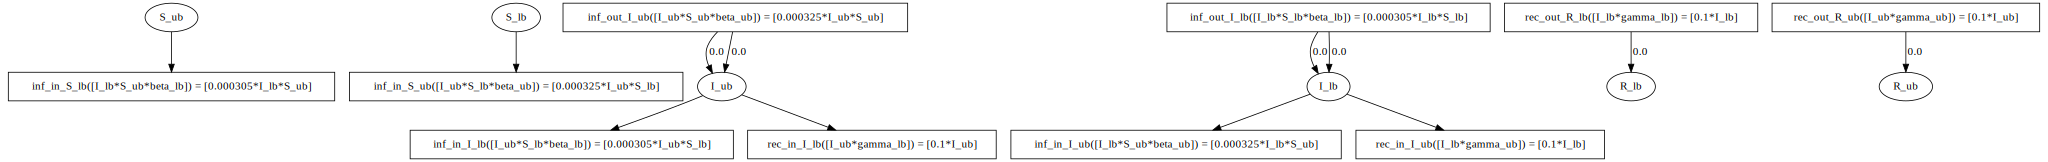

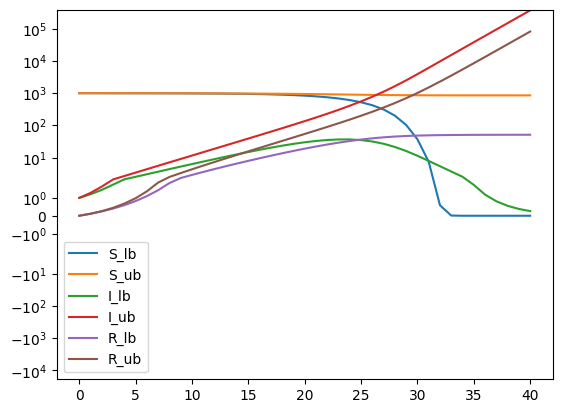

In [4]:
# 1.1) Bound the Base Model (support parameter synthesis for beta)

bounded_model: GeneratedPetriNetModel = base_model.formulate_bounds()

# Modify the beta parameter bounds by beta_modifier
parameters = bounded_model.petrinet.semantics.ode.parameters
beta_1 = next(p for p in parameters if p.id == "beta_lb")
beta_2 = next(p for p in parameters if p.id == "beta_ub")
beta_1.value -= beta_modifier
beta_2.value += beta_modifier

# Save the modified model
bounded_model_str = f"{model_str}_bounded"
bounded_model_path = os.path.join(EXAMPLE_DIR, bounded_model_str+".json")
models[bounded_model_str] = bounded_model_path
with open(bounded_model_path, "w") as f:
    f.write(bounded_model.petrinet.model_dump_json())


# 1.2) Analyze Bounded Base Model

bounded_request = FunmanWorkRequest() 
setup_common(bounded_request, timepoints, mode=MODE)
bounded_results = run(bounded_request, bounded_model_str, models)
report(bounded_results, bounded_model_str, bounded_model._state_var_names() + bounded_model._observable_names(), request_results, request_params, plot_logscale=True)
bounded_model.to_dot()

                        beta gamma             total_time model_size  \
sir                 0.000315   0.1 0 days 00:00:00.152909          7   
sir_bounded              NaN   NaN 0 days 00:00:00.682955         20   
sir_stratified_100       NaN   0.1 0 days 00:00:46.197466        304   

                   time_horizon   beta_lb   beta_ub gamma_lb gamma_ub  \
sir                          40       NaN       NaN      NaN      NaN   
sir_bounded                  40  0.000305  0.000325      0.1      0.1   
sir_stratified_100           40       NaN       NaN      NaN      NaN   

                   beta_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_31_32_33_34_35_36_37_38_39_40_41_42_43_44_45_46_47_48_49_50_51_52_53_54_55_56_57_58_59_60_61_62_63_64_65_66_67_68_69_70_71_72_73_74_75_76_77_78_79_80_81_82_83_84_85_86_87_88_89_90_91_92_93_94_95_96_97_98_99_100_0  \
sir                                                               NaN                            

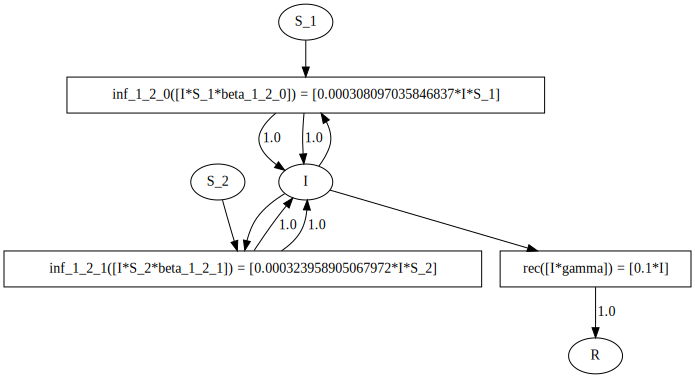

In [5]:
# 2.1) Stratify and Analyze the Base model with vaccination status


STRATA_SIZES = [2, 10, 25, 50, 100]
STRATA_SIZES.reverse()

for NUM_STRATA in STRATA_SIZES:
    stratified_model = base_model.stratify("S", [str(i+1) for i in range(0,NUM_STRATA)], strata_parameters=["beta"], self_strata_transition=False)

    # 2.2) Analyze Stratified Base Model    
    stratified_request = FunmanWorkRequest()

    # Modify the beta_1 and beta_2 parameters
    parameters = stratified_model.petrinet.semantics.ode.parameters
    for beta in (p for p in parameters if "beta" in p.id):
       beta.value += random.uniform(-beta_modifier, beta_modifier)

    stratified_model_str = f"{model_str}_stratified_{str(NUM_STRATA).zfill(3)}"
    stratified_model_path = os.path.join(EXAMPLE_DIR, stratified_model_str+".json")
    models[stratified_model_str] = stratified_model_path
    with open(stratified_model_path, "w") as f:
        f.write(stratified_model.petrinet.model_dump_json())

    setup_common(stratified_request, timepoints, mode=MODE)
    stratified_results = run(stratified_request, stratified_model_str, models)
    report(stratified_results, stratified_model_str, stratified_model._state_var_names() + stratified_model._observable_names(), request_results, request_params, plot=False)

# Only show the smallest
stratified_model.to_dot()

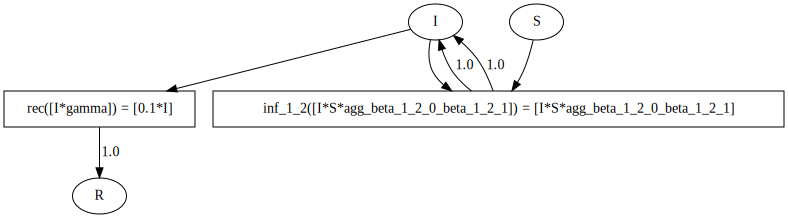

In [6]:
#  4)  Abstract the Stratified Base Model

abstract_stratified_model: GeneratedPetriNetModel = stratified_model.abstract({"S_1": "S", "S_2": "S"}) 

abstract_stratified_model_str = f"{model_str}_abstract_stratified"
abstract_stratified_model_path = os.path.join(EXAMPLE_DIR, abstract_stratified_model_str+".json")
models[abstract_stratified_model_str] = abstract_stratified_model_path
with open(abstract_stratified_model_path, "w") as f:
    f.write(abstract_stratified_model.petrinet.model_dump_json())

abstract_stratified_model.to_dot()

1 points
                                     beta gamma             total_time  \
sir                              0.000315   0.1 0 days 00:00:00.152909   
sir_bounded                           NaN   NaN 0 days 00:00:00.682955   
sir_stratified_100                    NaN   0.1 0 days 00:00:46.197466   
sir_stratified_050                    NaN   0.1 0 days 00:00:11.679174   
sir_stratified_025                    NaN   0.1 0 days 00:00:03.674596   
sir_stratified_010                    NaN   0.1 0 days 00:00:01.209570   
sir_stratified_002                    NaN   0.1 0 days 00:00:00.316371   
sir_abstract_stratified_bounded       NaN   NaN 0 days 00:00:00.672809   

                                model_size time_horizon   beta_lb   beta_ub  \
sir                                      7           40       NaN       NaN   
sir_bounded                             20           40  0.000305  0.000325   
sir_stratified_100                     304           40       NaN       NaN   
sir_stra

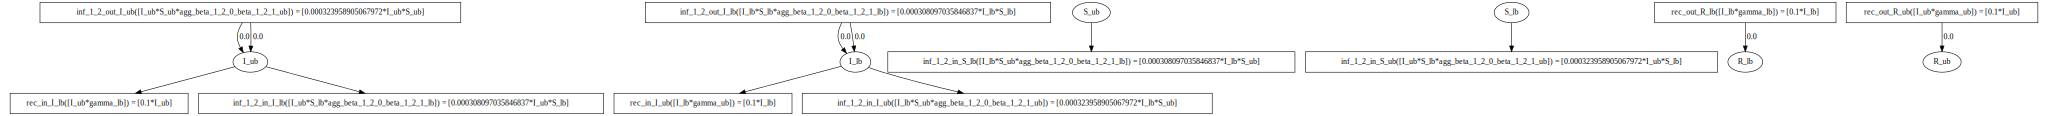

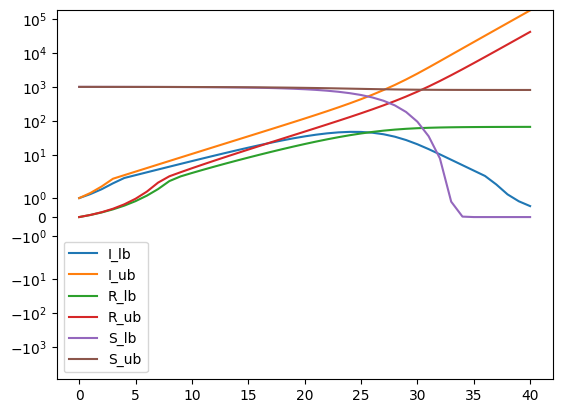

In [7]:
# 4) Bound and Analyze Abstract Stratified Bounded Base Model

# Bound the abstract stratified model
abstract_stratified_bounded_model: GeneratedPetriNetModel = abstract_stratified_model.formulate_bounds()
abstract_stratified_bounded_model_str = f"{model_str}_abstract_stratified_bounded"
abstract_stratified_bounded_model_path = os.path.join(EXAMPLE_DIR, abstract_stratified_bounded_model_str+".json")
models[abstract_stratified_bounded_model_str] = abstract_stratified_bounded_model_path
with open(abstract_stratified_bounded_model_path, "w") as f:
    f.write(abstract_stratified_bounded_model.petrinet.model_dump_json())

abstract_stratified_bounded_request = FunmanWorkRequest() #get_request(requests[abstract_stratified_bounded_model_str])
setup_common(abstract_stratified_bounded_request, timepoints, mode=MODE)
abs_results = run(abstract_stratified_bounded_request, abstract_stratified_bounded_model_str, models)
report(abs_results, abstract_stratified_bounded_model_str, abstract_stratified_bounded_model._state_var_names() + abstract_stratified_bounded_model._observable_names(), request_results, request_params, plot_logscale=True)
abstract_stratified_bounded_model.to_dot()

In [8]:
# Check if bounds are correct bounds

# Timeseries for base model
bs = [s for s in base_results.model._symbols() if s != "timer_t"]
base_df = base_results.dataframe(base_results.points())[bs]

# Timeseries for stratified model
ss = [s for s in stratified_results.model._symbols() if s != "timer_t"]
stratified_df = stratified_results.dataframe(stratified_results.points())[ss]
stratified_df["S"] = stratified_df.S_1 + stratified_df.S_2
destratified_df = pd.DataFrame(stratified_df)

# Timeseries for bounded abstract model
bass = [s for s in abs_results.model._symbols() if s != "timer_t"]
bounded_abstract_df = abs_results.dataframe(abs_results.points())[bass]


# Determine whether all values in values_df fall within the interval in bounds_df
def check_bounds(bounds_df, values_df, variable, values_model_name):
    failures = []
    lb = f"{variable}_lb"
    ub = f"{variable}_ub"
    if not all(values_df[variable] >= bounds_df[lb]):
        failures.append(f"The bounded abstract model does not lower bound the {values_model_name} model {variable}:\n{pd.DataFrame({lb:bounds_df[lb], variable: values_df[variable], f'{variable}-{lb}':values_df[variable]-bounds_df[lb]})}")
    if not all(values_df[variable] <= bounds_df[ub]):
        failures.append(f"The bounded abstract model does not upper bound the {values_model_name} model {variable}:\n{pd.DataFrame({ub:bounds_df[ub], variable: values_df[variable], f'{ub}-{variable}':bounds_df[ub]-values_df[variable]})}")
    return failures

# Check each state variable of the non-bounded models against the bouneded model 
all_failures = []
for (values_df, model) in [(base_df, "base"), (destratified_df, "stratified")]:
    for var in ["S", "I", "R"]:
        all_failures += check_bounds(bounded_abstract_df, values_df, var, model)

# Report any cases where the bounds are violated, suggesting a bug
reasons = '\n'.join(map(str, all_failures))
assert len(all_failures) == 0, f"The bounds failed in the following cases:\n{reasons}"

In [10]:
# Summarize the runtime of the different models
runtime_stats_dataframe(request_params).sort_index()

,Model Size,Total Time,Time Horizon
Model,,,
sir,7,0 days 00:00:00.152909,40
sir_abstract_stratified_bounded,20,0 days 00:00:00.672809,40
sir_bounded,20,0 days 00:00:00.682955,40
sir_stratified_002,10,0 days 00:00:00.316371,40
sir_stratified_010,34,0 days 00:00:01.209570,40
sir_stratified_025,79,0 days 00:00:03.674596,40
sir_stratified_050,154,0 days 00:00:11.679174,40
sir_stratified_100,304,0 days 00:00:46.197466,40
